PART 1 

In [56]:
# Importing Libraries 
import cv2
import numpy as np 
from matplotlib import pyplot as plt
import pickle
import os

In [57]:
# Functions 

def get_images(img_dir_path):
    images = []
    for i in range(64):
        image = cv2.imread(os.path.join(img_dir_path,'image_%03d.png'%(i)))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = gray.astype(np.float32) / 255.0
        images.append(gray)

    return images 

def get_light_directions(light_dirs_path): 
   # Load lighting direction vectors
    light_dirs = pickle.load( open( light_dirs_path, "rb" ) )
    return light_dirs


"""
find_height_map: returns [192x168] numpy array of heights

surface_normals: _________ numpy array of surface normal vectors
"""

def find_height_map(surface_normals, integration_method):
   
   sn_x = surface_normals[:,:,0]
   sn_y = surface_normals[:,:,1]
   sn_z = surface_normals[:,:,2]

   # Computing partial derivatives REMOVE NEGATIVE
   delta_x = sn_x/sn_z
   delta_y = sn_y/sn_z

   # Initialise height_map
   row, col = sn_x.shape
   height_map_row = np.zeros((row, col)) 
   height_map_col = np.zeros((row, col)) 
   height_map_avg = np.zeros((row, col)) 

   # ------ROW-WISE--------------------------------------------
   # Cumulative sum over first row 
   height_map_row[0,:] = np.cumsum(delta_x[0,:])

   # Summing down each column 
   for i in range(1, row): 
      height_map_row[i, :] = height_map_row[i-1, :] + delta_y[i, :]

   
   # ------COL-WISE--------------------------------------------
   # Cumulative sum down first column 
   height_map_col[:,0] = np.cumsum(delta_y[:,0])

   # Summing across each row
   for i in range(1, col): 
      height_map_col[:, i] = height_map_col[:, i-1] + delta_x[:, i]


   # ------AVERAGE---------------------------------------------
   height_map_avg = (height_map_row+height_map_col)/2
   

   if integration_method == "row wise":
      return height_map_row
   
   elif integration_method == "column wise": 
      return height_map_col
   
   elif integration_method == "average": 
      return height_map_avg

   return None



def find_albedo_normals(images, light_directions):
    
    # Collate all the pixel data for each pixel from each light source 
    images = np.stack(images, axis=2)  
    print(images.shape)

    # Image dimesnions
    height, width, num_images = images.shape
   
    # Calculating albedo and normals 
    albedo = np.zeros((height, width))
    normals = np.zeros((height, width, 3))

    for h in range(height): 
        for w in range(width): 
            intensities = images[h, w, :]
            g_xy, _, _, _ = np.linalg.lstsq(light_directions, intensities, rcond = None)
            albedo[h,w] = np.linalg.norm(g_xy)      # magnitude of g_xy
            normals[h,w,:] = g_xy/albedo[h,w]       # direction of g_xy

    return albedo, normals





"""
plot_face_3d: produces textured 3D mesh of face data

height_map: [192x168] numpy array of heights
albedo: [192x168] numpy array of albedos (between 0-1)

Note: x-axis displayed in figure is flipped for better viewing
"""
def plot_face_3d(height_map, albedo, title):

    h, w = albedo.shape[:2]

    X, Y = np.meshgrid(np.arange(w, 0, -1), np.arange(0, h))
    fc = np.empty([h, w, 3])
    fc[:,:,0] = albedo
    fc[:,:,1] = albedo
    fc[:,:,2] = albedo

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(X, Y, height_map, facecolors=fc, rstride=1, cstride=1)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)
   #  ax.axis('equal')
   #  ax.axis('auto')

    plt.show()


In [58]:
# Reading in Datasets 

# Path to images and light direction data 
img01_dir_path = 'yale_face_data/image_dir_B01'
light01_dirs_path = 'yale_face_data/light_dirB01.pkl'
img02_dir_path = 'yale_face_data/image_dir_B02'
light02_dirs_path = 'yale_face_data/light_dirB02.pkl'
img05_dir_path = 'yale_face_data/image_dir_B05'
light05_dirs_path = 'yale_face_data/light_dirB05.pkl'
img07_dir_path = 'yale_face_data/image_dir_B07'
light07_dirs_path = 'yale_face_data/light_dirB07.pkl'


# Extract images and light direction data 
images_01 = get_images(img01_dir_path)
light_directions_01 = get_light_directions(light01_dirs_path)
images_02 = get_images(img02_dir_path)
light_directions_02 = get_light_directions(light02_dirs_path)
images_05 = get_images(img05_dir_path)
light_directions_05 = get_light_directions(light05_dirs_path)
images_07 = get_images(img07_dir_path)
light_directions_07 = get_light_directions(light07_dirs_path)


# Extract albedo and surface normals data 
B01_data_path = 'yale_face_data/B01_albedo_normals.pkl'
data = pickle.load( open( B01_data_path, "rb" ) )
albedo_01 = data['albedo_image']
surface_normals_01 = data['surface_normals']

albedo_02, surface_normals_02 = find_albedo_normals(images_02, light_directions_02)
albedo_05, surface_normals_05 = find_albedo_normals(images_05, light_directions_05)
albedo_07, surface_normals_07 = find_albedo_normals(images_07, light_directions_07)



(192, 168, 64)
(192, 168, 64)
(192, 168, 64)


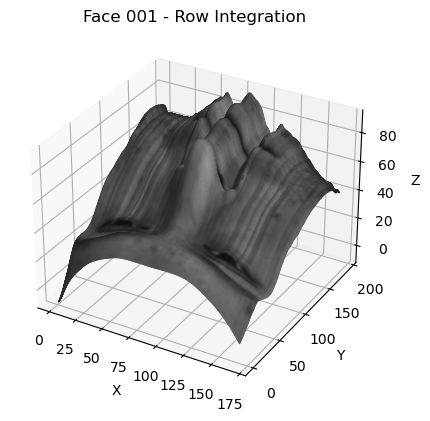

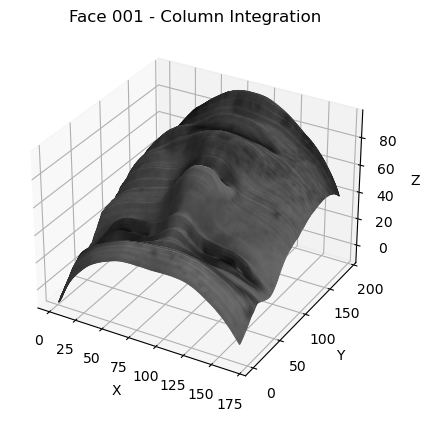

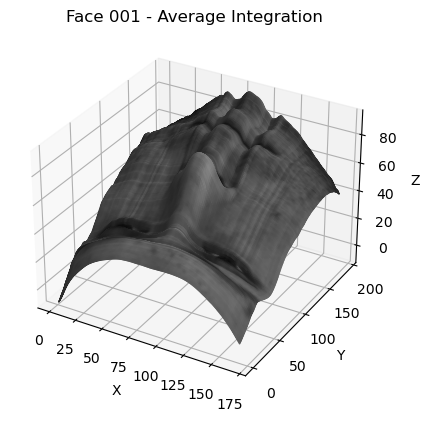

In [59]:
# Producing 3D plots of all faces 

integration_method = "average"

height_map_01_av = find_height_map(surface_normals_01, integration_method)
height_map_02_av = find_height_map(surface_normals_02, integration_method)
height_map_05_av = find_height_map(surface_normals_05, integration_method)
height_map_07_av = find_height_map(surface_normals_07, integration_method)

integration_method = "row wise"

height_map_01_row = find_height_map(surface_normals_01, integration_method)
height_map_02_row = find_height_map(surface_normals_02, integration_method)
height_map_05_row = find_height_map(surface_normals_05, integration_method)
height_map_07_row = find_height_map(surface_normals_07, integration_method)

integration_method = "column wise"

height_map_01_col = find_height_map(surface_normals_01, integration_method)
height_map_02_col = find_height_map(surface_normals_02, integration_method)
height_map_05_col = find_height_map(surface_normals_05, integration_method)
height_map_07_col = find_height_map(surface_normals_07, integration_method)



plot_face_3d(height_map_01_row, albedo_01, "Face 001 - Row Integration")
plot_face_3d(height_map_01_col, albedo_01, "Face 001 - Column Integration")
plot_face_3d(height_map_01_av, albedo_01, "Face 001 - Average Integration")



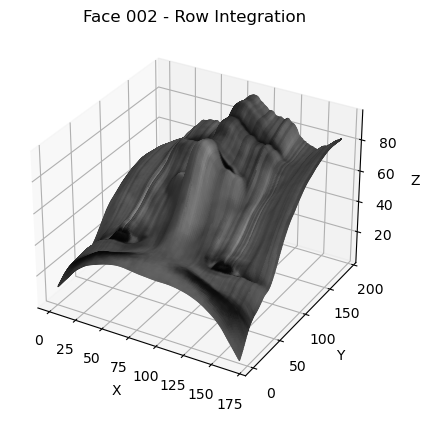

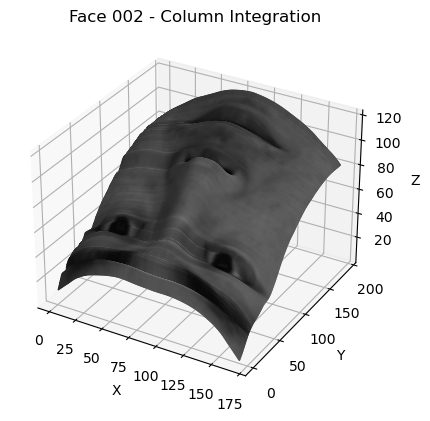

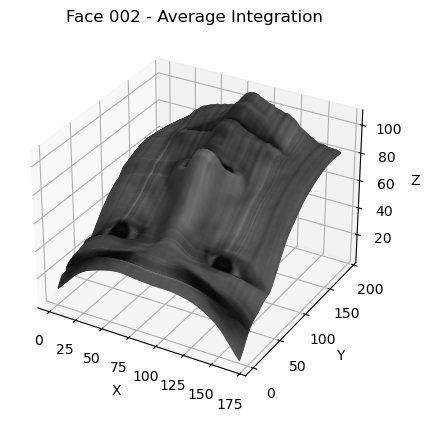

In [60]:
plot_face_3d(height_map_02_row, albedo_02, "Face 002 - Row Integration")
plot_face_3d(height_map_02_col, albedo_02, "Face 002 - Column Integration")
plot_face_3d(height_map_02_av, albedo_02, "Face 002 - Average Integration")

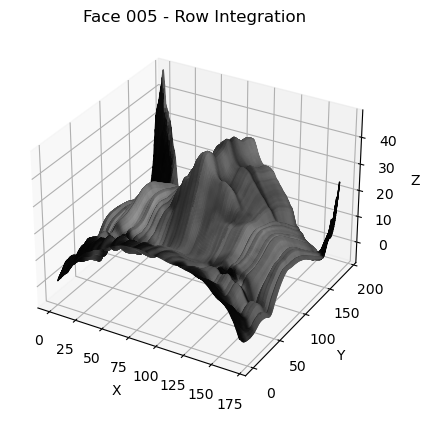

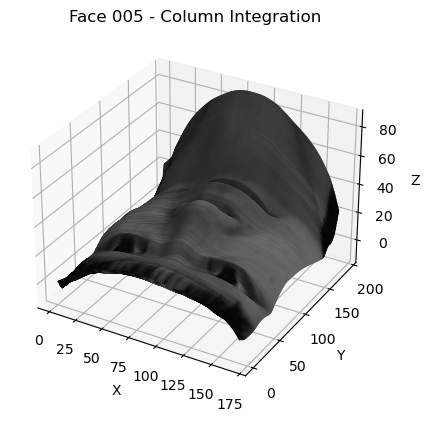

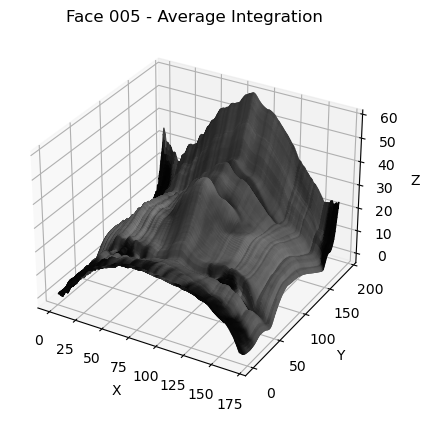

In [61]:
plot_face_3d(height_map_05_row, albedo_05, "Face 005 - Row Integration")
plot_face_3d(height_map_05_col, albedo_05, "Face 005 - Column Integration")
plot_face_3d(height_map_05_av, albedo_05, "Face 005 - Average Integration")

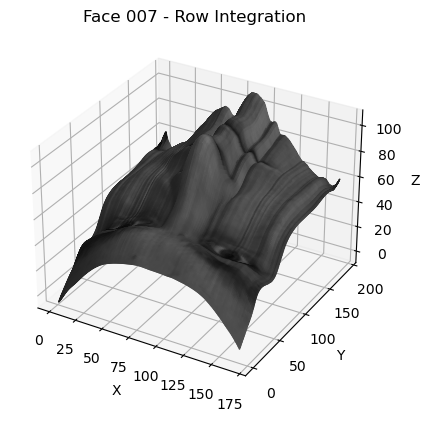

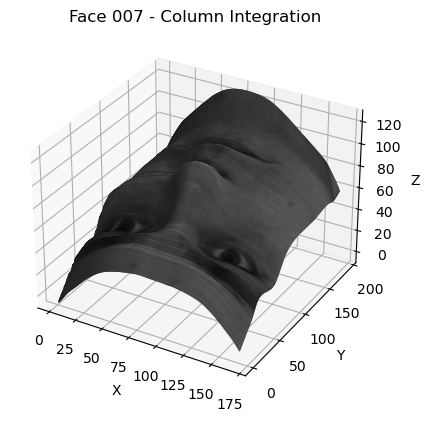

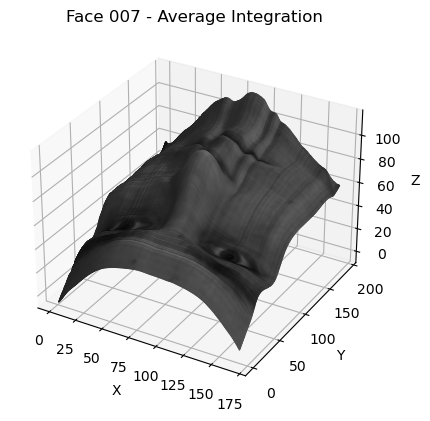

In [62]:
plot_face_3d(height_map_07_row, albedo_07, "Face 007 - Row Integration")
plot_face_3d(height_map_07_col, albedo_07, "Face 007 - Column Integration")
plot_face_3d(height_map_07_av, albedo_07, "Face 007 - Average Integration")

## PART 2 - Reducing Noise

In [63]:
# Functions for computing residuals 

def compute_residuals(images, albedo, light_directions, surface_normals): 

   # Re-format images 
   images = np.stack(images, axis=2) 
   height, width, num_images = images.shape 

   residuals = np.zeros((height, width, num_images))
   
   for i in range(num_images): 
      I_rendered = albedo*(np.dot(surface_normals, light_directions[i]))
      I_rendered = np.clip(I_rendered,0, 255)


      # Compute residuals
      residuals[:, :, i] = images[:, :, i] - I_rendered


   h, w, num = residuals.shape

   residual_mask = np.zeros((h, w, num))

   std_devs = np.std(residuals, axis=2)

   for i in range(num_images):
      residual_mask[:, :, i] = np.abs(residuals[:, :, i]) > (2 * std_devs[:,:])


   return residual_mask, residuals 


def plot_residual_magnitude(residual_mask): 

    
   fig, axes = plt.subplots(8, 8, figsize=(12, 12))
   for i, ax in enumerate(axes.flat):
      ax.imshow(residual_mask[:,:,i], cmap='gray')
      ax.set_title(f'{i}')
      ax.axis('off')
   plt.suptitle("Pixels with Residuals Greater than 2x Standard Deviation")
   plt.tight_layout()
  
   return None



def find_albedo_normals_residuals(images, light_directions, residual_mask):
   
    # Image dimesnions
    images = np.stack(images, axis=2) 
    height, width, num_images = images.shape 

    # Calculating albedo and normals 
    albedo = np.zeros((height, width))
    normals = np.zeros((height, width, 3))

   
    for h in range(height):
        for w in range(width):
            valid_mask = (residual_mask[h, w, :] == 0)
            valid_indices = np.where(valid_mask)[0]

            if len(valid_indices) < 3:
                continue

            intensities = images[h, w, valid_indices]
            light_dirs = light_directions[valid_indices]

            # Solve for g using least squares
            g_xy, _, _, _ = np.linalg.lstsq(light_dirs, intensities, rcond=None)
            norm = np.linalg.norm(g_xy)

            if norm > 0:
                albedo[h, w] = norm
                normals[h, w, :] = g_xy / norm  
            
    return albedo, normals





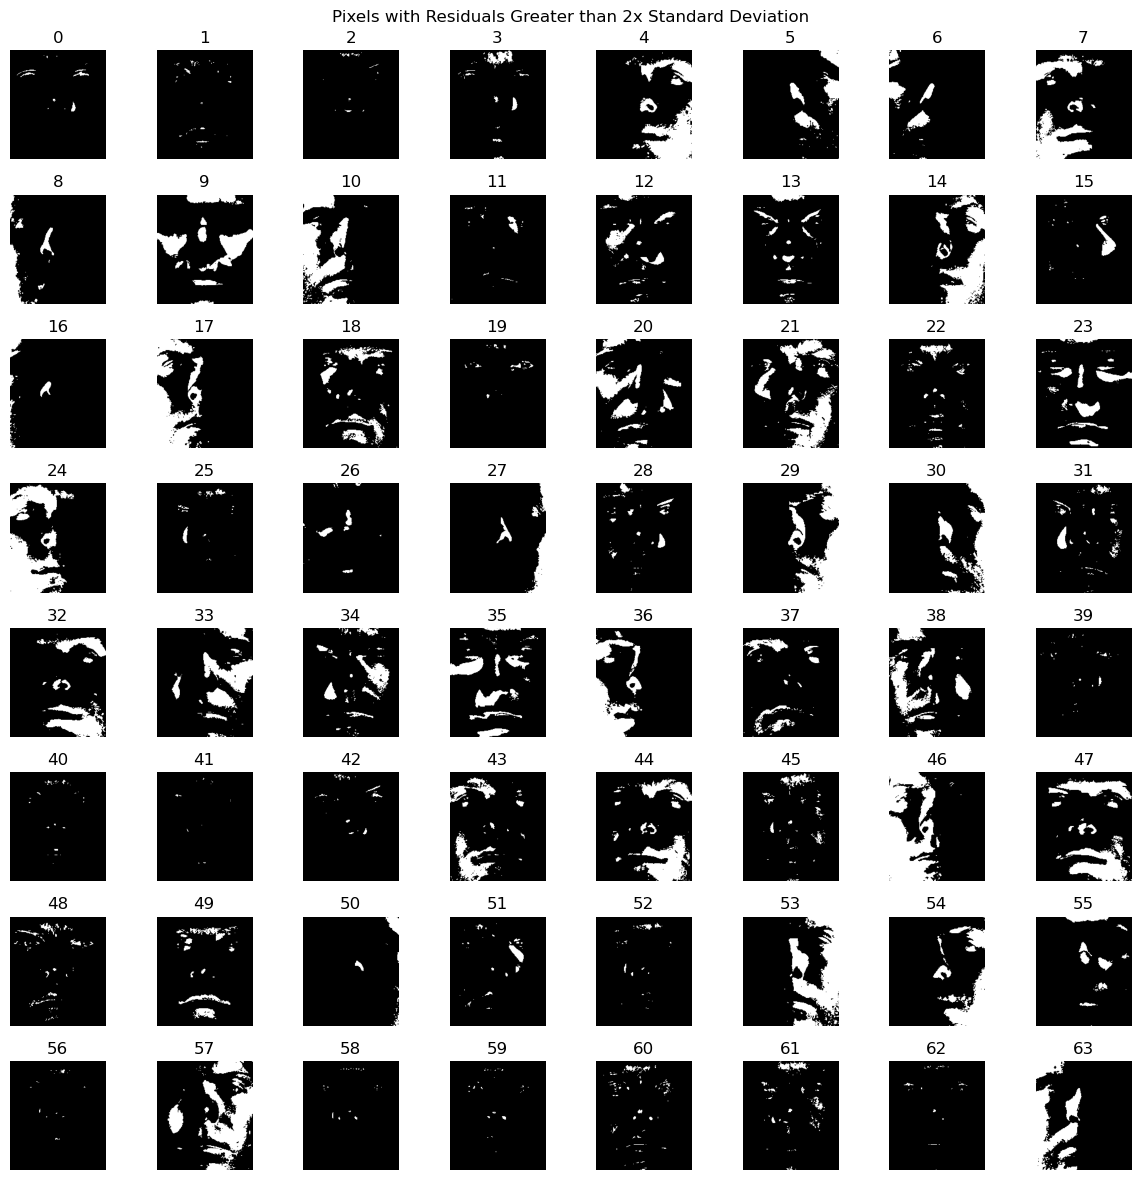

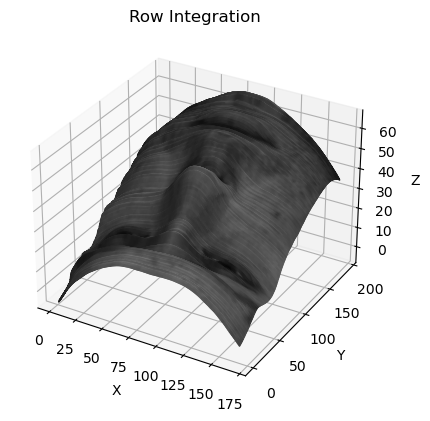

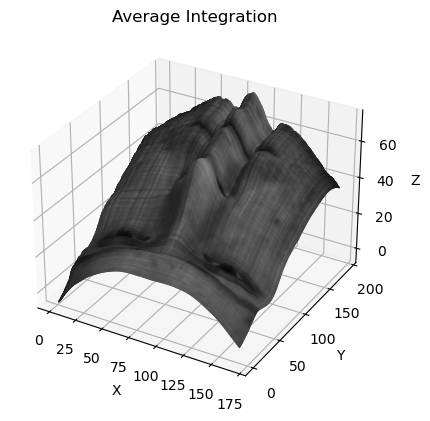

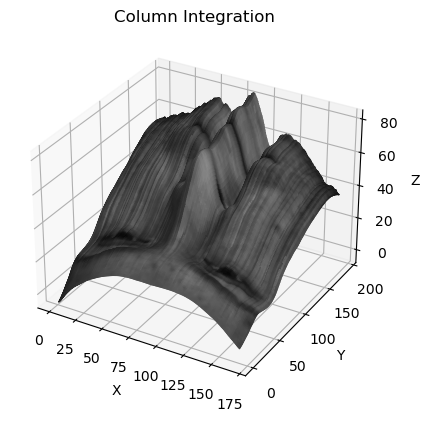

In [ ]:

residual_mask_01, residuals_01 = compute_residuals(images_01, albedo_01, light_directions_01, surface_normals_01)

plot_residual_magnitude(residual_mask_01)


albedo_residuals_01, normal_residuals_01 = find_albedo_normals_residuals(images_01, light_directions_01, residual_mask_01)

integration_method = "average"
height_map_residuals_01_av = find_height_map(normal_residuals_01, integration_method)

integration_method = "row wise"
height_map_residuals_01_col = find_height_map(normal_residuals_01, integration_method)

integration_method = "column wise"
height_map_residuals_01_row = find_height_map(normal_residuals_01, integration_method)

plot_face_3d(height_map_residuals_01_row, albedo_residuals_01, "Row Integration")
plot_face_3d(height_map_residuals_01_col, albedo_residuals_01, "Column Integration")
plot_face_3d(height_map_residuals_01_av, albedo_residuals_01, "Average Integration")


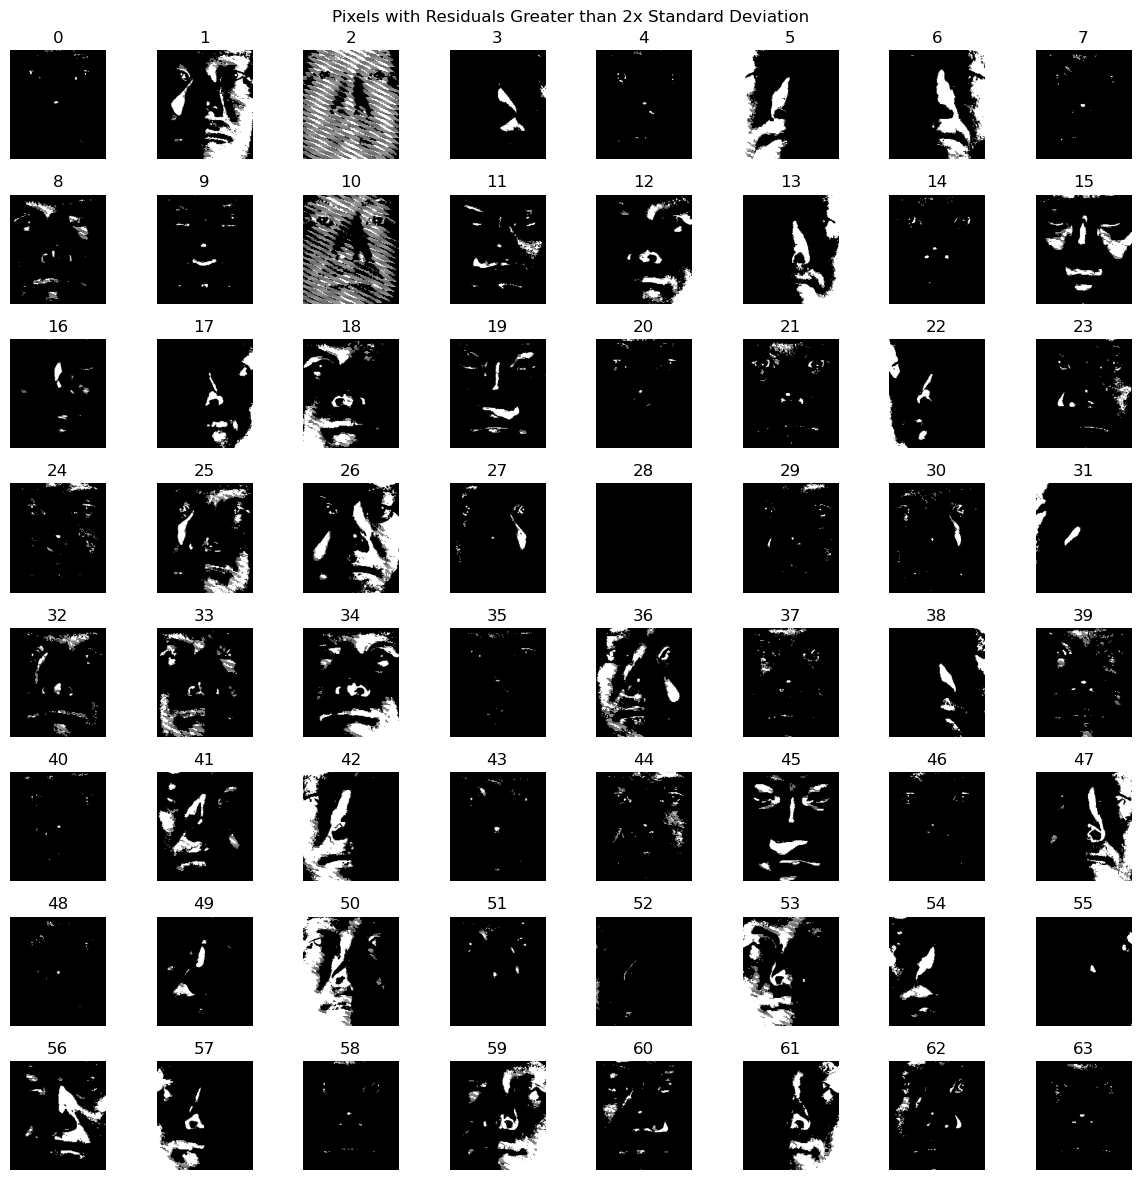

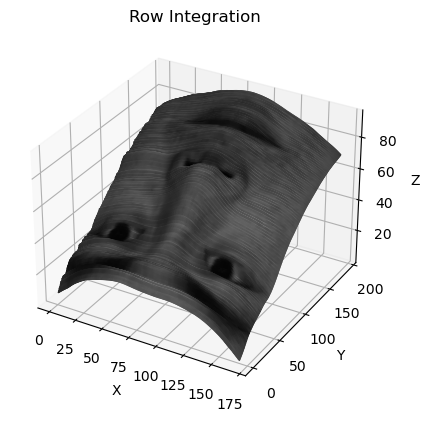

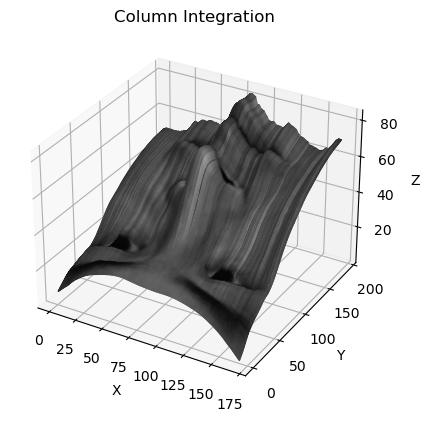

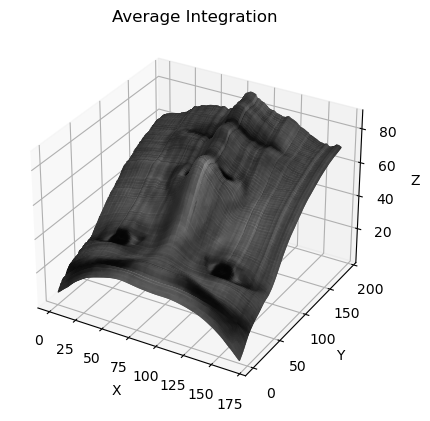

In [68]:
residual_mask_02, residuals_02 = compute_residuals(images_02, albedo_02, light_directions_02, surface_normals_02)

plot_residual_magnitude(residual_mask_02)


albedo_residuals_02, normal_residuals_02 = find_albedo_normals_residuals(images_02, light_directions_02, residual_mask_02)

integration_method = "average"
height_map_residuals_02_av = find_height_map(normal_residuals_02, integration_method)

integration_method = "row wise"
height_map_residuals_02_col = find_height_map(normal_residuals_02, integration_method)

integration_method = "column wise"
height_map_residuals_02_row = find_height_map(normal_residuals_02, integration_method)

plot_face_3d(height_map_residuals_02_row, albedo_residuals_02, "Row Integration")
plot_face_3d(height_map_residuals_02_col, albedo_residuals_02, "Column Integration")
plot_face_3d(height_map_residuals_02_av, albedo_residuals_02, "Average Integration")

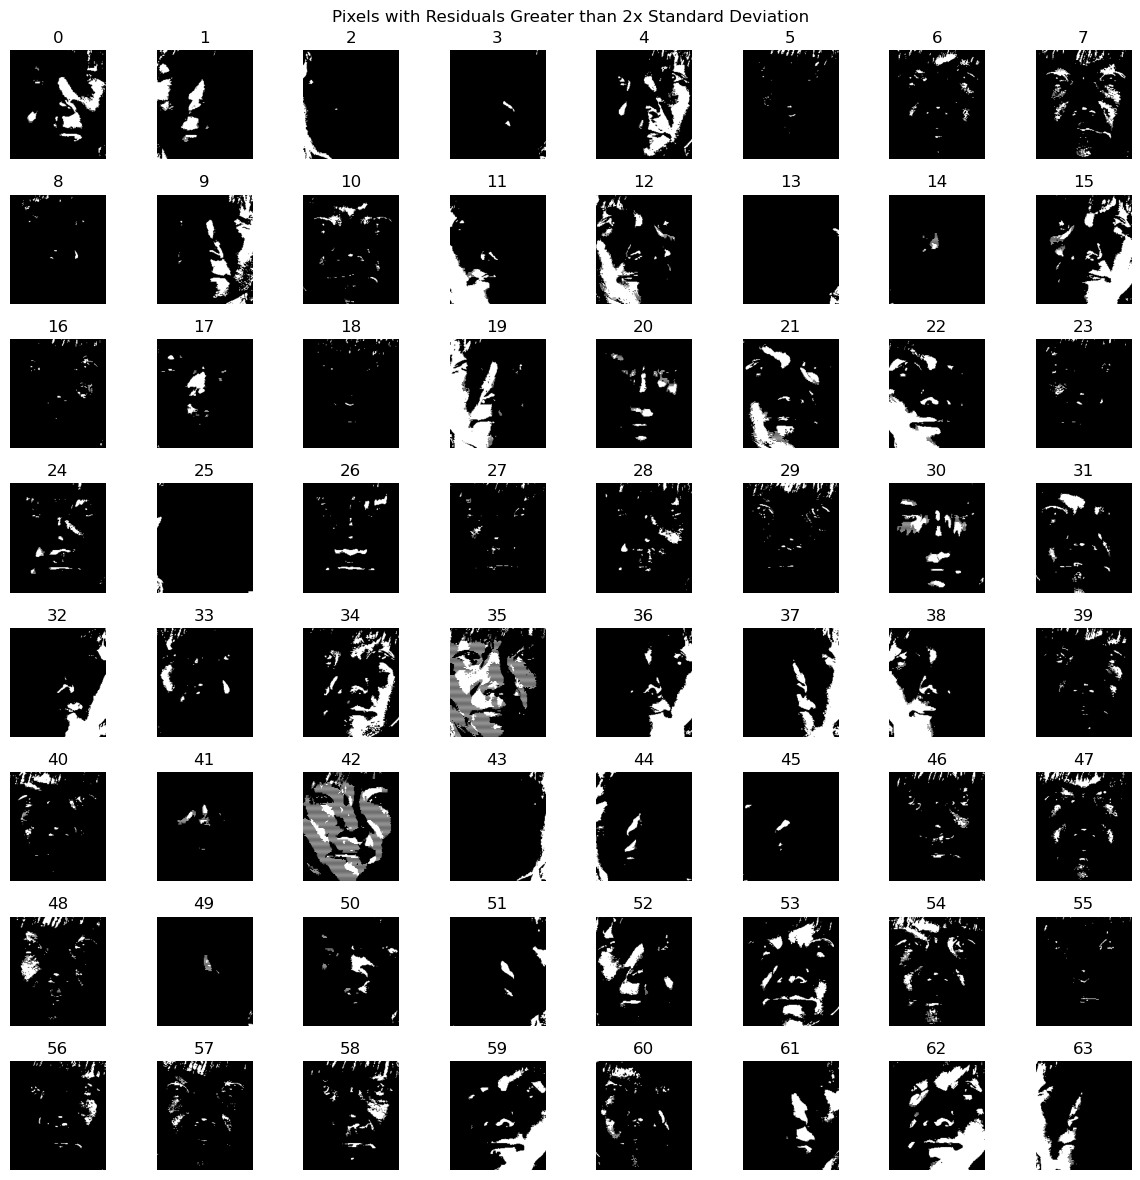

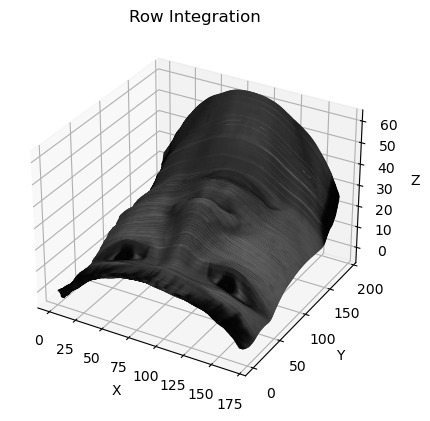

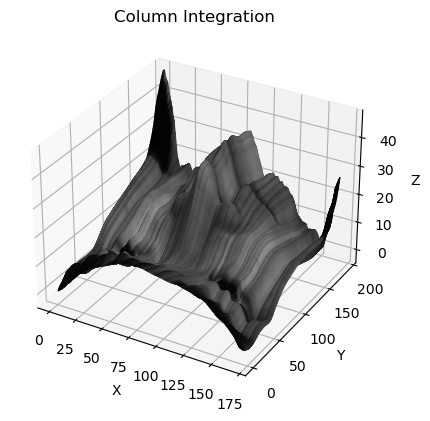

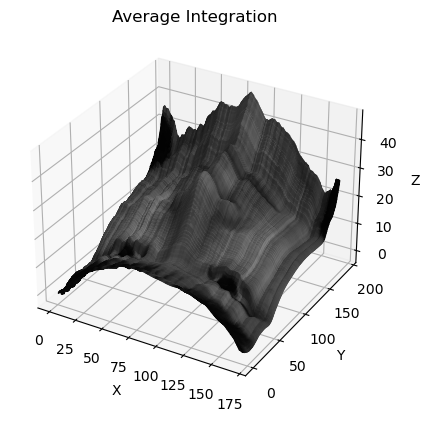

In [69]:
residual_mask_05, residuals_05 = compute_residuals(images_05, albedo_05, light_directions_05, surface_normals_05)

plot_residual_magnitude(residual_mask_05)


albedo_residuals_05, normal_residuals_05 = find_albedo_normals_residuals(images_05, light_directions_05, residual_mask_05)

integration_method = "average"
height_map_residuals_05_av = find_height_map(normal_residuals_05, integration_method)

integration_method = "row wise"
height_map_residuals_05_col = find_height_map(normal_residuals_05, integration_method)

integration_method = "column wise"
height_map_residuals_05_row = find_height_map(normal_residuals_05, integration_method)

plot_face_3d(height_map_residuals_05_row, albedo_residuals_05, "Row Integration")
plot_face_3d(height_map_residuals_05_col, albedo_residuals_05, "Column Integration")
plot_face_3d(height_map_residuals_05_av, albedo_residuals_05, "Average Integration")

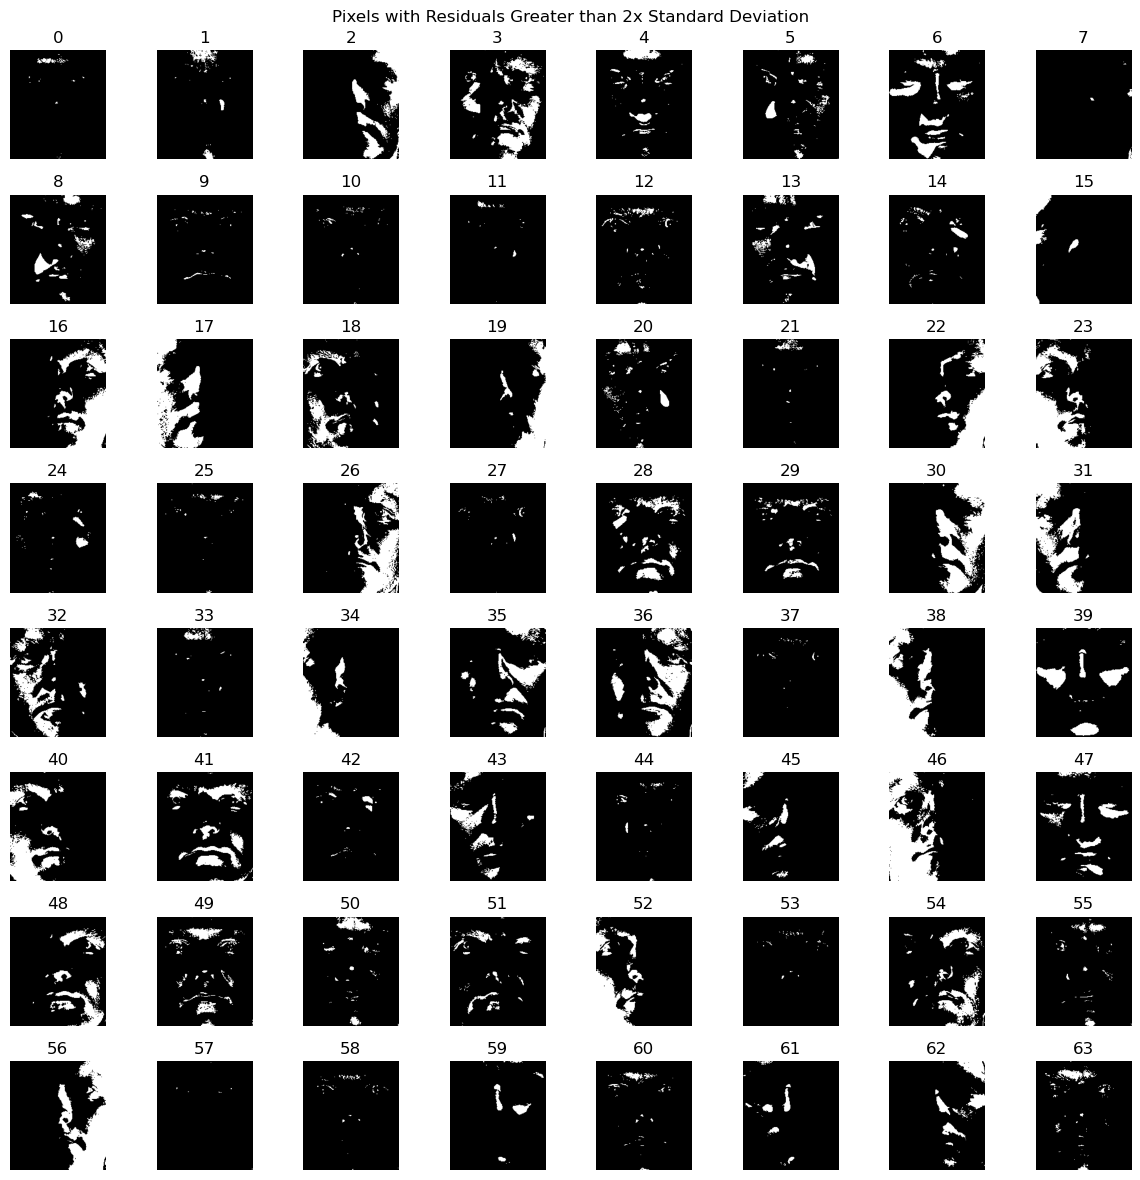

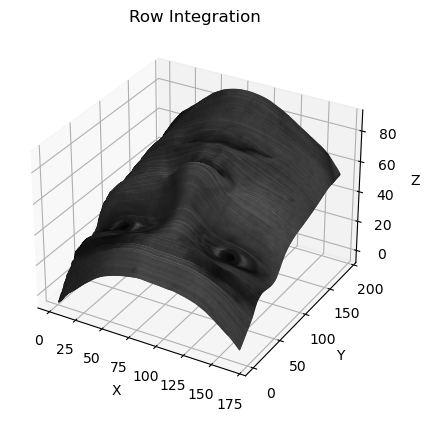

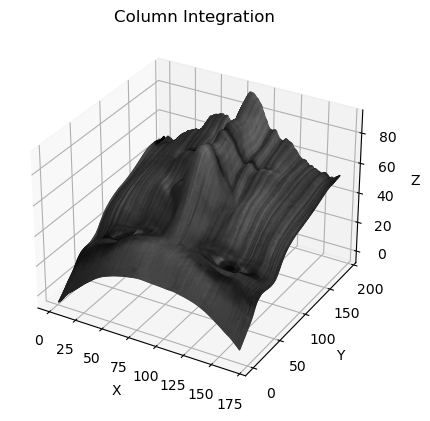

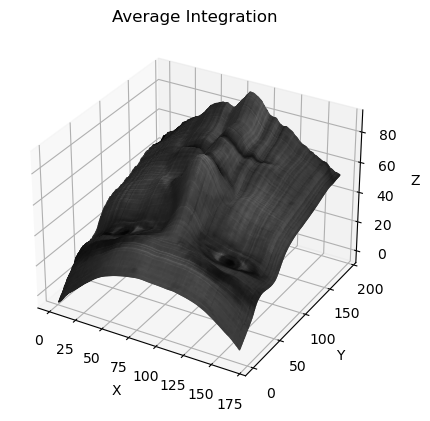

In [70]:
residual_mask_07, residuals_07 = compute_residuals(images_07, albedo_07, light_directions_07, surface_normals_07)

plot_residual_magnitude(residual_mask_07)


albedo_residuals_07, normal_residuals_07 = find_albedo_normals_residuals(images_07, light_directions_07, residual_mask_07)

integration_method = "average"
height_map_residuals_07_av = find_height_map(normal_residuals_07, integration_method)

integration_method = "row wise"
height_map_residuals_07_col = find_height_map(normal_residuals_07, integration_method)

integration_method = "column wise"
height_map_residuals_07_row = find_height_map(normal_residuals_07, integration_method)

plot_face_3d(height_map_residuals_07_row, albedo_residuals_07, "Row Integration")
plot_face_3d(height_map_residuals_07_col, albedo_residuals_07, "Column Integration")
plot_face_3d(height_map_residuals_07_av, albedo_residuals_07, "Average Integration")